<font color=red>**Note!**</font> This notebook was created by Vahan Geghamyan as a final project of "Machine Learning and Dynamic Models" in Peking University HSBC Business School, under the instruction of  Prof. Thomas Sargent, Prof. Xianhua Peng, Dr. Chase Coleman, and Dr. Spencer Lyon.

**Title**: Application of Kalman Filter in Asset Pricing: Estimation of No-Arbitrage Autoregressive Term Structure Model with Macroeconomic and Latent Variables

 ## Summary
 
---
In this project, I discuss and implement the estimation of an Affine Term Structure Model (ATSM) using the Kalman filter. The ATSM is a family of models that describe the relationship between interest rates and the time to maturity of bonds. The model assumes that the yields are affine functions of underlying state variables. These models are widely used in fixed-income pricing, risk management, and interest rate forecasting. They provide a framework to understand and predict the term structure of interest rates, which is essential for pricing bonds, options, and other fixed-income securities. I provide an illustrative explanation of the codes and show how to estimate parameters and compute the hidden states when you don't have the parameters. This includes the pricing of bonds and the estimation of latent factors that drive the yield curve. I also provide intuitive explanations of asset pricing concepts from my understanding in the blue boxes, which will be helpful for the reader. In appendix B, I provide an introduction and a small literature review for readers who find the topic interesting and want to understand it better. This project assumes the reader has some basic knowledge about finance and time series analysis.

---

**Keywords:** Kalman Filter, Latent Factors, Affine Term Structure Models, Risk-Neutral Pricing


**Prerequisites:** 

- Linear State Space Models
- Kalman Filter
- Statistics
- Time Series 


In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import re

from statsmodels.api import OLS
from statsmodels.tsa.api import VAR
import statsmodels.api as sm

from scipy.optimize import minimize
import scipy.linalg

from quantecon import Kalman, LinearStateSpace

from ipywidgets import interact, widgets

## Table of Contents

- 1. Introduction
- 2. Data Collection and Processing
- 3. Model Construction
    - 3.1 Short rate dynamics
    - 3.2 State variable dynamics
    - 3.3 Pricing Kernel
    - 3.4 Bond Prices
- 4. Model Estimation
    - 4.1 Model Summary and Parameterization
    - 4.2 Parameter Estimation
    - 4.3 A "Second" Look at the Kalman Filter
    - 4.4 Estimation
- 5. Estimation Results
    - 5.1 Results
    - 5.2 Impulse Responses
    - 5.3 Strenght and Limitation
- 6. Conclusion

## 1. Introduction

In reality, the interest rates that influence consumer spending, business investment, and overall economic activity are medium - and long-term rates. However, the interest rate that the central banks use to manage monetary policy are the short term interest rates (Mishkin, 2015). Interest rates affect the present value of future cash flow of an asset, which means they are also very important for pricing any assets such as stocks, bonds, and financial derivatives. Thus, understanding how changes in short-term interest rates influence the entire term structure and gaining insights into its dependence on macroeconomic variables provides valuable knowledge for investors, policymakers, and economists. The term structure of interest rates, or the yield curve, refers to the relationship between interest rates (or the yields) and the time to maturity of bonds. Bond yields represent the return an investor receives from holding a bond, typically expressed as a percentage of the bond's face value. Given the $n$-period zero-coupon bond price, $P_t^n$, the yield between time $t$ and $t+n$ are defined to be $$y_t^n = - \frac{1}{n} \log P_t^n \tag{1}$$ or, equivalently, $$P_t^n = \exp\{-n y_t^n\}. \tag{2}$$

For a $d$-dimensional vector $x$, an affine function of $x$ takes the following form: $f(x) = a + b'x = a + b_1 x_1 + \ldots + b_d x_d$. The function $g(x)$ is an exponential affine function if the logarithm of that function is an affine function of $x$, i.e., $\log g(x) = f(x)$. Assuming that bond prices are exponential affine functions of underlying state variables, equation (1) implies that the yields are affine functions of those variables. Thus, an Affine Term Structure Models (ATSMs) are a family of models of the term structure where the yields are affine function of the underlying state variables. 

Latent variables are unobserved variables that influence or drive observed measurements and are widely employed in asset pricing to capture unobserved sources of risk and return. In the context of bond markets, latent variables describe the information present in the yields or bond prices that govern the market. Many term structure models use models with similar factors to explain term structure movements. In fact, the entire yield curve moves primarily in response to changes in a small (normally three) number of latent factors (Dai and Singleton, 2000). However, the factors have not been given a direct comparison with macroeconomic variables. Ang and Piazzesi (2003) provided a framework that directly links macro and latent variables to government bond yields. In this report, I follow their framework to establish the link between macro and latent variables and the entire term structure, representing this relationship within a linear state space dynamic system. Then, I utilize the Kalman filter and Non-linear Least Squares (LS) to  estimate the values of the latent variables and parameters, respectively.

I will introduce the model in a way that the reader will not need any other knowledge than econometrics and some basic asset pricing theory concepts to understand the model. However, it would be very useful for the reader to take a small detour and read the [Appendix B](#Appendix_B), where I provide a brief introduction to affine term structure models. This will help the reader to better understand the model setup and gain more insight into latent factors.

In section 2, I outline the complete process of data collection and processing. Moving on to section 3, I present the construction of the term structure model following Ang and Piazzesi (2003), accompanied by intuitive explanations provided in blue boxes to address any potential knowledge gaps for the reader. Section 4 provides a detailed introduction to the estimation process. Section 5 reports the results, and finally, section 6 gives us the conclusion.

## 2. Data Collection and Processing

I use US data on zero coupon bond yield of maturities 1, 3, 8, 12, 36, and 60 months from December 1980 to December 2022 from CRSP. I got data on macro variables for the same period from FRED. The bond yields (12, 36 and 60 months) are from the Risk free rates files, while the shorter maturity rates (1 and 3 months) are from the CRSP TREASURIES - Fama Treasury Bill Term Structure files.

Macro variables include a proxy for US economic activity growth, and Inflation rate. The proxy for economic activity growth is the year-over-year growth Coincident Economic Activity Index for the United States (Series ID: USPHCI) and the inflation is the year-over-year growth rate of the Consumer Price Index for all items (Series ID: CPALTT01USM659N). I will work with monthly frequency.

In [2]:
# Define some helper functions for importing and plotting data 

def import_yield_data(file_name: str):
    """
    Imports yield data from an Excel file and preprocesses it.
    
    Args:
        file_name (str): Name of the Excel file.
        
    Returns:
        pd.DataFrame: Preprocessed yield data with columns 'time_to_maturity', 'date', and 'yield'.
    """
    df = pd.read_excel(file_name, names=['time_to_maturity', 'date', 'yield'])
    df_ = df.pivot('date', 'time_to_maturity')
    df_.columns = df_.columns.droplevel(0)
    df_.index = pd.to_datetime(df_.index).to_period("M")
    
    return df_


def import_macro_data(file_name: str, name: str):
    """
    Imports macro data from an Excel file and preprocesses it.
    
    Args:
        file_name (str): Name of the Excel file.
        name (str): Name of the macro data column.
        
    Returns:
        pd.DataFrame: Preprocessed macro data with 'date' as the index and the specified column name.
    """
    df = pd.read_excel(file_name, names=['date', name])
    df.index = pd.to_datetime(df.date)
    df.index = df.index.to_period("M")
    
    df.drop(['date'], axis=1, inplace=True)
    
    return df


def plot_yields(df):
    """
    Plots the yield data.
    
    Args:
        df (pd.DataFrame): Yield data with 'time_to_maturity' and 'date' columns.
    """
    df.plot(figsize=(10, 6))

    for year in range(df.index.year[0], df.index.year[-1] + 1):
        plt.axvline(pd.Timestamp(year=year, month=1, day=1), linestyle='--', alpha=0.3)
    
    plt.legend(fontsize=12, frameon=False, bbox_to_anchor=(1, 1))
    plt.ylabel("Yield to Maturity")
    plt.xlabel("Date")
    plt.title("Yields")
    plt.show()
    
    
def plot_macros(df):
    """
    Plots the macro data.
    
    Args:
        df (pd.DataFrame): Macro data with 'date' as the index.
    """
    df.plot(figsize=(10, 6))

    for year in range(df.index.year[0], df.index.year[-1] + 1):
        plt.axvline(pd.Timestamp(year=year, month=1, day=1), linestyle='--', alpha=0.3)
    
    plt.legend(fontsize=12, frameon=False, bbox_to_anchor=(1, 1))
    plt.ylabel("Percent")
    plt.xlabel("Date")
    plt.title("Macro variables")
    plt.show()

    
def yield_curve_data(yields_short, yields_long):
    """
    Combines short-term and long-term yield data to create a dataframe for 
    plottingthe yield curve.
    
    Args:
    yields_short (DataFrame): DataFrame containing short-term yield data.
    yields_long (DataFrame): DataFrame containing long-term yield data.
    
    Returns:
    plot_data (DataFrame): Combined and processed dataframe for plotting.
    """
    new_columns = dict(zip(yields_short.columns, [1, 3]))
    yields_short.rename(columns=new_columns, inplace=True)
    
    # Convert the column names to integers that represent the term to maturity in months
    maturity_months = []
    for column in yields_long.columns:
        match = re.search(r'(\d+)-Year', column)
        if match:
            maturity = int(match.group(1)) * 12  # Convert years to months
            maturity_months.append(maturity)

    new_columns = dict(zip(yields_long.columns, maturity_months))
    yields_long.rename(columns=new_columns, inplace=True)
    
    plot_data = pd.concat([yields_short, yields_long], axis=1).dropna(axis=0)
    
    plot_data = plot_data.resample("A").max()
    
    return plot_data    

def plot_yield_curve(Year):
    """
    Plot the yield curve for a specific year, uses the data processed by
    function `yield_curve_data` previously defined.
    
    Args:
    Year (int or str): Target year for plotting the yield curve.
    
    Returns:
    None
    """
    # Filter the data frame for the target date
    curve = plot_yields_df.loc[str(Year)]
    curve.sort_index(inplace=True)

    # Create subplots
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Plot the yields as a function of the term to maturity
    ax.plot(curve.index, curve.values, marker='o')
    ax.set_xlabel('Term to Maturity')
    ax.set_ylabel('Yield')
    ax.set_title(f'Yields as a Function of Term to Maturity ({Year})')
    ax.grid(True)
    
    plt.show()

def add_lags(macro_data, lags=12):
    """
    Add lagged variables to the macro_data DataFrame as new columns. 
    
    Args:
    macro_data (DataFrame): Input DataFrame containing macroeconomic data.
    lags (int): Number of lags to add.
    
    Returns:
    estimation_data (DataFrame): DataFrame with lagged variables.
    """
    df = macro_data.copy()
    
    # Initialize the column order list
    column_order = ['g', 'inf']

    # Create the lagged columns for 'g' and 'inf' variables
    for lag in range(1, lags):
        column_order.append(f'g_L{lag}')
        column_order.append(f'inf_L{lag}')
        df[f'g_L{lag}'] = df['g'].shift(lag)
        df[f'inf_L{lag}'] = df['inf'].shift(lag)

    # Create the estimation_data DataFrame with selected column order
    estimation_data = df[column_order].copy()
    
    # Drop the missing values
    estimation_data.dropna(inplace=True, axis=0)
    
    return estimation_data


def normalize(df):
    """
    Normalizes the data by subtracting the mean and dividing by the standard deviation.
    
    Args:
        df (pd.DataFrame): Data to be normalized.
        
    Returns:
        pd.DataFrame: Normalized data.
    """
    df_n = (df - df.mean(axis=0)) / df.std(axis=0)
    
    return df_n


In [4]:
# Import short rates, select first two columns (yields for 1 month and 3 month maturities),
# drop rows with missing values
yields_short = import_yield_data("Data/short_rates.xlsx").iloc[:, :2].dropna(axis=0)

# Import zero coupon bond rates
yields_long = import_yield_data("Data/zero_coupons.xlsx")

# Select the bonds with maturity of 12, 36, 60 months.
zcbs = import_yield_data("Data/zero_coupons.xlsx").iloc[:, [0, 2, 4]]

# Concatenates the tbills and zcbs dataframes horizontally (along the columns) to combine the yield data
yields_data = pd.concat([yields_short, zcbs], axis=1).dropna(axis=0)

# Rename the columns of the yields dataframe using the new column names
new_columns = dict(zip(list(yields_data), ['1m', '3m', '12m', '36m', '60m']))
yields_data.rename(columns=new_columns, inplace=True)

# Import and calculate the 12-month difference (year-on-year change) for the 'economic activity' column
g = import_macro_data("Data/USPHCI.xls", 'g').diff(12) 
inf = import_macro_data("Data/CPALTT01USM657N.xls", 'inf')

# Normalize the EA and inf dataframes using the normalize function and
# concatenates the normalized g and inf dataframes horizontally 
macro_data = pd.concat([normalize(g), normalize(inf)], axis=1).dropna(axis=0)

# Create a new DataFrame that adds 12 lags of each variable as a new column. Will be used for the estimation
macro_lags = add_lags(macro_data, lags=12)#.loc[:"2002-12", :] # By uncommenting you can compare the results
                                                               # with Ang and Piazzesi (2003)
# Use only the observations that are present in all datasets
period_macro = macro_data.index.intersection(macro_lags.index)
period = period_macro.intersection(yields_data.index)
yields_data = yields_data.loc[period]
X_obs = macro_lags.loc[period]         # Rename for convenience
macro_data = macro_data.loc[period]


Please note that I use normalized data for two reasons: (i) Plotting and (ii) Compatibility with factors that we will assume to be distributed normally.

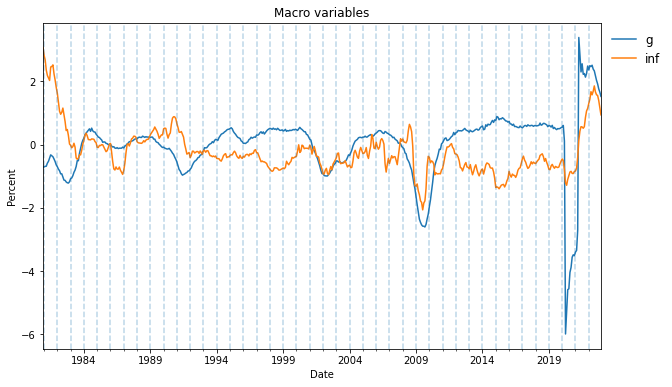

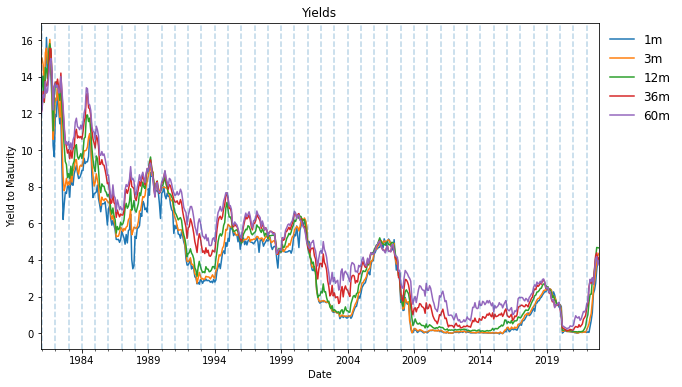

In [5]:
# Plot the time series: yields and the macroeconomic variables 
plot_macros(macro_data)
plot_yields(yields_data)

In [6]:
# Plot the yield curve. Restart the kernel before rerunning
plot_yields_df = yield_curve_data(yields_short, yields_long)
interact(plot_yield_curve, Year=widgets.IntSlider(min=2004, max=2022))

interactive(children=(IntSlider(value=2004, description='Year', max=2022, min=2004), Output()), _dom_classes=(…

<function __main__.plot_yield_curve(Year)>

To further motivate you, let's explore the interactive figure above, which plots the yield curve at different points in time. 

In general, the yield curve reflects the relationship between the interest rates of bonds with different maturities, providing insight into market expectations for future interest rates and economic conditions. Loosely speaking, it can be used for predicting economic trends and interest rate changes by analyzing the shape, slope, and shifts in the yield curve over time (although it is not a straightforward task as the shape is influenced by numerous factors). By moving the slider above we can see how the curve has looked liked from 2004 to 2022. 

It is worth noting that the yield curve in 2006 (pre-financial crisis), 2019 (early stages of the COVID-19 pandemic), and as of 2022 exhibit somewhat similar shapes.

Wait, what? Is there a **recession** coming? ...

In [6]:
# Compute correlations
pd.concat([macro_data, yields_data.iloc[:, ::2]], axis=1).corr()

,g,inf,1m,12m,60m
g,1.000000,0.207426,-0.032379,-0.020560,-0.067470
inf,0.207426,1.000000,0.621985,0.628157,0.578235
1m,-0.032379,0.621985,1.000000,0.985666,0.950036
12m,-0.020560,0.628157,0.985666,1.000000,0.977308
60m,-0.067470,0.578235,0.950036,0.977308,1.000000


The table above displays the correlations between the macro variables and yields with maturities of 1 month, 12 months, and 60 months. As we can see, not only are yields correlated with macro variables, but they are also correlated with each other. We can leverage this relationship to construct a term structure model.



## 3.   Model Construction

I closely follow the model construction approach outlined by Ang and Piazzesi (2003). In their work, they fitted three models: the Yields-only model (with latent factors only), the Macro model (incorporating both latent and macro factors), and the Macro lag model (incorporating both latent and macro factors along with 12 lags of the macro factors). I will proceed to construct the Macro lag model below, providing a detailed explanation of the intuition behind each step. Please pay attention to the explanations presented in the blue boxes as they provide clarifications for the underlying concepts.


### 3.1   Short rate dynamics 

When considering the relationship between interest rates and macroeconomic variables such as GDP growth and inflation, it is natural for economists to turn to the policy rule proposed by Taylor (1993). According to this rule, the changes in the short-term interest rate should be attributed to fluctuations in contemporaneous macro variables, represented by a vector $f^o_t$, along with an unexplained component that is orthogonal to the macro variables, denoted as $\nu_t$. Let $f_t^o = (f^o_{1, t}, f^o_{2, t})'$, where $f^o_{1, t}$ and $f^o_{2, t}$ are the macro variables (Here, $f^o_{1, t}$ is the proxy for GDP growth, and $f^o_{2, t}$ is the inflation). Mathematically, the policy rule can be expressed as follows:

\begin{equation}
r_t = a_0 + a_1' f^o_t + \nu_t  \tag{3}
\end{equation}

In the equation above, $r_t$ represents the short-term interest rate, $a_0$ is a constant term, $a_1'$ is the vector of coefficients, and $f^o_t$ is a vector of the macro variables. The shock term $\nu_t$ captures any unexplained influence on the interest rate not accounted for by the macro variables. It can be interpreted as a **monetary policy shock**.

The Taylor rule **can be extended** to include the lags of macro variables in the right-hand side of equation (1) (Clarida, Gali, and Gertler, 2000). The extended equation can be written as:

\begin{equation}
r_t = b_0 + b_{1,0}' f^o_t + b_{1,1}' f^o_{t-1} + ... +  b_{1,p}' f^o_{t-p} + w_t  \tag{4}
\end{equation}

In equation (2), $b_{1,0}, b_{1,1}, ..., b_{1,p}$ represent the coefficient vectors corresponding to the lagged macro variables $f^o_{t-1}, f^o_{t-2}, ..., f^o_{t-p}$ (recall that $f^o_{t-i} = (f^o_{1, t-i}, f^o_{2, t-i})'$ ). 

Let $X_t^o = (f^o_{t-1}, f^o_{t-2}, ..., f^o_{t-12})'$, where $f^o_{t-1}, f^o_{t-2}, ..., f^o_{t-12}$ are the same as above. Define a vector $X_t^u = (f^u_{1, t}, f^u_{2, t}, f^u_{3, t})$, where $f^u_{1, t}$, $f^u_{2, t}$, and $f^u_{3, t}$ are three latent variables. Assume $X_t^u$ and $X_t^o$ are **orthogonal**. 

The **short term dynamics** that is used by Ang and Piazzesi (2001) is

\begin{equation}
r_t=\delta_0+\delta_{11}' X_t^o+\delta_{12}' X_t^u  \tag{5}
\end{equation}

The difference between the short rate dynamics given by the equation (5) and the policy rule in equation (4) is that in the former, the error term (the monetary shock) is specified to be an affine function of latent factors. If you're confused, please refer to [Appendix B](#Appendix_B), where you will find more information about the affine specification of interest rates.

<div class="alert alert-block alert-info">
<b>Intuition: Finding a state is an art</b> 
    
The reason for using a similar policy rule is that, as we will see in the next section, we want to connect the macro factors to the interest rate. This connection allows us to utilize the information contained in these macro factors when pricing bonds by expressing their prices in terms of these variables. 

When pricing the bonds, macro variables act as state variables. State variables contain all the relevent information that the model needs to know about the economy. However, in reality, two macro variables (GDP growth and inflation) are insufficient to represent all the factors that drive bond prices. As quoted in our lectures, "finding a state is an art." Indeed, we cannot blindly add more state variables because selecting state variables involves certain tradeoffs (see Cochrane (2008) for more details). 

Once again, we need to find state variables that include all the relevant information for the bond pricing model. We have already identified two variables (inflation and GDP growth), but these two variables are not enough. The short rate dynamics also includes lagged values of the macro variables. The intuition behind doing so is that contemporaneous values alone may not capture all the information present in the macroeconomic aggregates that we observe. By incorporating the lags, the vector of observable state variables is expanded to include 24 observed variables, instead of the original two. Still not enough!

To solve this issue we note that the information that is contained in the true state variables (that drive the bond prices) are also reflected in the observed bond prices themselves. Therefore, we want to extract some of this additional information from the bond prices that are not captured by the macro variables, and use them as state variables. These are the latent variables that we see in equation (4).
</div>



In [7]:
# Short rate dynamics (observables)
r = yields_data['1m']
X = sm.add_constant(X_obs)
results_r = OLS(r,X).fit()

# results_r.summary()

print(f"The adjusted R-sqared is {results_r.rsquared_adj: 0.3f}")

The adjusted R-sqared is  0.543


By uncommenting results_r.summary() above, you can view the regression results where we regress the short rate on the economic growth, inflation variable, and their lags. The adjusted R-square is reported above. If we had used only the observable variables as state variables, we would effectively assume that the information explaining nearly 50% of the variation in short rates drives the entire bond market, which certainly is not the case!

### 3.2   State variable dynamics 

After defining the short rate dynamics, we need to define the dynamics of both macro, $X_t^o$, and latent variables, $X_t^u$. We assume $f_t^o = (f^o_{1, t}, f^o_{2, t})'$ follows a Gaussian VAR(12) process, which can be written in the first-order companion form using vector $X_t^o = (f^o_{t-1}, f^o_{t-2}, ..., f^o_{t-12})'$. If you are not familiar with this form, please check section 1.2 of the following [link](https://kevinkotze.github.io/ts-7-var/) or refer to any other textbook on time series analysis. This is necessary for understanding the model estimation and deriving the impulse response functions later. Thus, observable state dynamics can be written as:
$$
X_t^o = \phi_0 + \phi_1 X_{t-1}^o + \Omega \epsilon_t^o,   \tag{6}
$$

where $\phi_0$, $\phi_1$, $\Omega$, and $\epsilon_t^o$ are **restrected** to have first-order companion form. You can uncomment the line `results_obs.summary()` below to see the results of the VAR estimation.


In [8]:
# VAR(12)
results_obs = VAR(macro_data, freq="M").fit(12)
# results_obs.summary()   # Uncomment to see the results


Latent factors, $X_t^u = (f^u_{1, t}, f^u_{2, t}, f^u_{3, t})$, are assumed to follow the process:

$$
X_t^u = \rho X_{t-1}^u + \epsilon_t^u,\tag{7}
$$

with $\epsilon_t^u \stackrel{\text{i.i.d.}}{\sim} \text{N}(0, I)$. The 3$\times$3 matrix $\rho$ is **restricted** to be lower triangular to ensure identification. For further details, refer to Dai and Singleton (2000) who provide a comprehensive description of affine term structure models and specify the conditions for identifying such models.

The shock processes $\epsilon_t^o$ and $\epsilon_t^u$ are assumed to be independent. Let $X_t = {({X_t^o}^{\prime}, {X_t^u}^{\prime})}^{\prime}$ and $\epsilon_t = (\epsilon_t^o, \epsilon_t^u)'$. The dynamics of $X_t$ can be compactly expressed as a first-order Gaussian VAR:

$$
X_t = \mu + \Phi X_{t-1} + \Sigma \epsilon_t\tag{8}
$$

where $\mu =\begin{bmatrix} \phi_0 \\ 0 \end{bmatrix}$, $ \Phi =\begin{bmatrix}\phi_1  & 0 \\ 0 & \rho \end{bmatrix}$, and $ \Sigma =\begin{bmatrix}\Omega  & 0 \\ 0 & I \end{bmatrix}$.


It is important to note that the yields can be expressed as affine functions of the state vector $X_t$, and thus **equation (7) can be interpreted as the transition equation of a state space system**.

<div class="alert alert-block alert-info">
So what we need is a law of motion for our state variables. In their paper, Ang and Piazzesi (2003) assume that the observables follow an unconstrained VAR(12) process, while the unobservables follow a VAR(1) process with the restriction that the coefficient matrix is lower triangular. We can extend this framework by using a larger vector and parameter matrices to express the VAR(12) process in VAR(1) form. Furthermore, we can stack the observable and unobservable vectors together to form a state vector. Since we already know how different parts or blocks of this vector evolve, the only thing we need to do is to describe these state variables simultaneously using a unified process. This is what the equation (8) does.
</div>

### 3.3   Pricing Kernel

In the previous subsections, we defined the dynamics of the state variables and linked them to the short rate by defining its dynamics. The next step is to link the short rate (and thus the state variables) to the bond prices. To do this, we will use risk-neutral pricing. I won't provide a detailed explanation, but I will try to explain the basic idea.


<div class="alert alert-block alert-info">
From a perspective of microeconomics or asset pricing theory, risk-neutral pricing is an approach to value an asset under the assumption that investors are indifferent to risk.  It involves discounting expected future payoffs of the asset at a risk-free rate, providing a fair price that does not reflect the asset's inherent risk but rather the risk-free rate of return. See Cochrane (2008) for more details. From a statistical perspective, we are changing the distribution of a random variable without changing the variable itself. In other words, we change the distribution that asset prices follow without changing the prices. See chapter 5 of Shreve (2010) for more details. When we change the distribution of the asset, we change its measure. In finance, the data-generating measure (the real measure) is sometimes called measure P, while the risk-neutral measure is called measure Q.


</div>

Under the assumption of no-arbitrage we can guarantee the existence of an risk-neutral measure $Q$ such that the price of any asset $V_t$ that does not pay any divident at time t+1 satisfies $V_{t}=E_{t}^{Q}( exp(-r_{t})V_{t+1})$, where the expectation is taken under the measure Q (or in other words, the expectation is taken with respect to the risk neutral distribution).

To connect the two measures, we need to use the Radon-Nikodym derivative, denoted as $\xi_t$. For any t+1 random variable $Z_{t+1}$, we have $E_t^Q(Z_{t+1}) = E_t(\frac{\xi_{t+1}}{\xi_t} Z_{t+1})$

Assume $\xi_{t+1}$ follows the log-normal process: $$\xi_{t+1}=\xi_t \exp \left(-\frac{1}{2} \lambda_t^{\prime} \lambda_t-\lambda_t^{\prime} \epsilon_{t+1}\right) \tag{8}$$

where $\lambda_t$ are the time-varying market prices of risk associated with the sources of uncertainty. $\lambda_t$ is parameterized as an affine process: $$\lambda_t=\lambda_0+\lambda_1 X_t   \tag{9}$$

where $\lambda_0 \in \mathbb{R} ^{5}$ and $\lambda_1 \in \mathbb{R} ^{5 \times 5}$, the number of observable and latent variables is five.

Define the pricing kernel $m_{t+1}$ as:$$ m_{t+1}=\exp \left(-r_t\right) \xi_{t+1} / \xi_t \text {.} \tag{10}$$

Substituting $r_t=\delta_0+\delta_1^{\prime} X_t$ we have:$$m_{t+1}=\exp \left(-\frac{1}{2} \lambda_t^{\prime} \lambda_t-\delta_0-\delta_1^{\prime} X_t-\lambda_t^{\prime} \epsilon_{t+1}\right).   \tag{11}$$


<div class="alert alert-block alert-info">
<b>Intuition</b> 
    
The central idea of modern finance is that prices are generated by expected discount payoffs, 

$$P_t = E_t(m_{t+1} X_{t+1})$$

where, $P_t$ represents the price of an asset and $X_{t+1}$ represents the random payoff of that asset at time t+1. The term $m_{t+1}$ is known as the stochastic discount factor (SDF). By dividing both sides of the equation by $P_t$, we obtain:  $1 = E_t(m_{t+1} R_{t+1})$, where, $R_{t+1} = X_{t+1}/p_t$ represents the return on the asset.  

There is one fundamental equation, and all the asset pricing revolves around finding this $m_{t+1}$ (Cochrane, 2008). If we consider the market return as our state variable and assume a linear SDF for stock returns, then the equation above will give us the well-known Capital Asset Pricing Model, also known as CAPM. In our case, we are focused on pricing bonds instead of stocks. We want to achieve this by using macro variables as state variables, and we have already established the relationship between the short rate and these macro variables. It turns out that if a risk-neutral measure exists, all assets will have a risk-free return (which we already have the dynamics for). Furthermore, the assumption of no arbitrage is equivalent to assuming the existence of $\xi_{t+1}$, which allows us to price any asset in the risk-neutral economy. Therefore, by using $m_{t+1}=\exp(-r_t) \xi_{t+1} / \xi_t$ as our SDF, we bring the asset into the risk-neutral world, price it there by discounting using the risk-free rate, and effectively establish a connection between bond prices and the state variables. We then bring it back to the real measure. This is why the choice of $m_{t+1}$ is so important.
    
Market prices of risk represent the extra return investors demand for taking on additional risk. These prices are influenced by both real-world factors, like economic conditions and investor preferences, and risk-neutral factors, which are typically related to the systematic sources of risk that impact asset prices. As we can see, these are the only parameters in the Radon-Nikodym derivative. They are unknown and need to be estimated.
</div>





### 3.4   Bond Prices  

Take equation (11) to be a nominal pricing kernel which prices all nominal assets in the economy. If $p_t^n$ represents the price of an $n$-period zero coupon bond, then the bond prices can be computed recursively by:
$$
{p}_t^{n+1}=E_t\left(m_{t+1} p_{t+1}^n\right) \tag{12}
$$

The short rate dynamics $r_t$ (Equation 5) together with the dynamics of the state variables $X_t$ (Equation 7) and the Radon-Nikodym derivative (Equation 8) form a discrete-time Gaussian five-factor model with two observable factors and three unobservable factors. 

The bond prices are exponential affine functions of the state variables. More precisely, bond prices are given by;
$$
p_t^n=\exp \left(\bar{A}_n+\bar{B}_n^{\prime} X_t\right) \tag{13}
$$
where the coefficients $\bar{A}_n$ and $\bar{B}_n$ follow the difference equations:
$$
\begin{aligned}
& \bar{A}_{n+1}=\bar{A}_n+\bar{B}_n^{\prime}\left(\mu-\Sigma^{\prime} \lambda_0\right)+\frac{1}{2} \bar{B}_n^{\prime} \Sigma \Sigma^{\prime} \bar{B}_n-\delta_0 \\
& \bar{B}_{n+1}^{\prime}=\bar{B}_n^{\prime}\left(\phi-\Sigma \lambda_1\right)-\delta_1^{\prime}
\end{aligned} \tag{14}
$$
with $\bar{A}_1=-\delta_0$ and $\bar{B}_1=-\delta_1$.
These difference equations can be derived by induction using equation (12), which is shown in the Appendix A. 

The continuosly compounded yields $y_t^n$ on an $n$-period zero coupon bond is given by: 

$$\begin{aligned}  y_t^n & = - \frac{\log p_t^n }{n} \\ & = A_n + B_n' X_t \\ & =  A_n + {B_n^o} ' X_t^o + {B_n^u} ' X_t^u \end{aligned}  \tag{15}$$

where $A_n = - \bar{A_n}/n$ and $B_n = - \bar{B_n}/n$. Note that  the yields are affine function of the state vector $X_t$ so the **equation (15) can be interpreted as being the observation equation of a state space system**.





<div class="alert alert-block alert-info">
<b>Intuition: Exponentially affine prices</b> 
    
Appendix B provides the motivation behind assuming an exponentially affine form for P(t, T) in the continuous case. However, in our current context, we work with stochastic difference equations instead of stochastic differential equations. To gain intuition and understanding for why this assumption is made, I recommend referring to [Appendix B](#Appendix_B). If you are interested in the derivation of the difference equations themselves, [Appendix A](#Appendix_A) provides the detailed derivation.
</div>

If you are confused about the model specification, it will be very helpful to look at Section 4 of the original paper by Ang and Piazzesi (2003). You can find the paper by following this [link](https://web.stanford.edu/~piazzesi/AP.pdf).

## 4. Model Estimation

In this section, I will provide a detailed explanation of the estimation process. Please note that I have focused on the **readability** of the code rather than its efficiency.

Before getting started I would like to point out what was the main challanges I faced in the estimation process, besides I want to introduce what other estimation methods are there and why I chose this particular one.

In their paper Ang and Piazzesi take the following approach, first they estimate the macro factors, then they regard them as given and astimate both the parameters and the latent factors simultaneuusly using MLE. But for estimating the latent factors they assume that the factors are analitical function of the yields. In other words, they used yields with five different maturities and they assumed that 1 month, 12 months, and 60 month yields uniquely specify the values for the latent variables. Because this linear relationship depends on the parameters, if one takes into account this relationship during the estimation, this will yield the best linear relationship that defines the latont factors.See [Ang and Piazzesi (2003)](https://web.stanford.edu/~piazzesi/AP.pdf) for mor e information. However, the results in the direct maximum likelihood case are very sensitive to the yields chosen to be priced without error. Moreover, because the values of the latent factors depend on the starting values chosen, this can result in a loss of precision in the confidence tervals (Duttee and Stanton, 2012). 

One way to solve this issue would be to calculate the likelihood under the Kalman filter and estimate the latent factors with the parameters simultaneously. This may result in more stable parameter estimates (Baker, 2014). The Kalman log-likelihood for each maturity can be calculated as indicated in Hamilton (1994, p. 385) and then summed over all maturities to get the total log-likelihood. For example, you can see the page 20 of [Schlooz (2019)](https://www.netspar.nl/assets/uploads/P20190821_MSc012_Schlooz.pdf), the algorithm for estimating the latent factors of multifactor Vasicek model using Kalman MLE. However, you can see that for doing the estimation of the model one may need good programming skills. 

I will take another approach to estimate the model. Instead of MLE, I will use Least Squares, and instead of nesting the computation directly, I will use the `Kalman` class from the `QuantEcon.py` package. This is not the most efficient way to do the estimation, but it is certainly simpler than constructing the Kalman MLE as in Hamilton (1994, p. 385) (see it yourself by following this [link](http://mayoral.iae-csic.org/timeseries2021/hamilton.pdf)). Thus, this simplicity will allow undergraduate and graduate students to experiment with models from the Affine term structure family with more ease. Another reason I take this approach is that initially, I was motivated to write about this topic to implement the Kalman Filtering algorithm given in the "A First Look at the Kalman Filter" lecture, and this way I can do it.

Before moving on, I want to mention that the paper "A Computational Approach to Affine Models of the Term Structure" by B. Baker was particularly helpful for this section.

### 4.1 Model Summary and Parameterization

The parameterization of the model is as follows:

- Estimation Parameters are $\theta =\{ \mu ,\Phi, \Sigma, \delta_0, \delta_1, \lambda_0, \lambda_1\} $


- State variables: $X_t = {({X_t^o}^{\prime}, {X_t^u}^{\prime})}^{\prime} = (f^o_{1, t}, ... ,f^o_{12, t}, f^u_{1, t}, f^u_{2, t}, f^u_{3, t})'$


- Short rate dynamics: $r_t = \delta_0+\delta_1' X_t$


- State dynamics: $X_t = \mu + \Phi X_{t-1} + \Sigma \epsilon_t,$ with $\epsilon_t \stackrel{\text{i.i.d.}}{\sim} \text{N}(0, I)$


- Market prices of risk: $\lambda_t=\lambda_0+\lambda_1 X_t$


- Observation Equation: $y_t^n   = A_n(\theta) + B_n(\theta)' X_t + \epsilon_t,$ where  $A_n(\theta)$ and $B_n(\theta)$ are given by Equation (7), and $\epsilon_t$ is the pricing error that is distributed Normally.

### 4.2 Parameter Estimation

In this section, I will explain the estimation process and go through the functions used for estimation.

First, let's start with the dynamics of the short rate and state variables. To simplify the estimation process, we can first estimate the coefficients related to the observable variables in the short rate dynamics and all the parameters in the state variables. Then, we can treat these estimated parameters as known and proceed to estimate the remaining variables. This approach is possible because we assume that the observable state variables, $X_t^o$, and the unobservable latent factors, $X_t^u$, are orthogonal. By following this approach, we can reduce the number of parameters to be estimated to 79. 

Specifically, the number of coefficients in the VAR(12) process for the two state variables is 54 (2 intercepts, 48 coefficients for the 12 2x2 matrices, and 4 elements for the variance-covariance matrix). Additionally, the number of coefficients corresponding to the observables in the short rate dynamics is 25 (1 intercept, 24 coefficients). The functions provided below will estimate the parameters for the observable variables and return the parameters in the required forms. For the state dynamics, the functions will compute the VAR(12) process for economic growth and inflation, and then return the parameters in the first-order companion form.

Note that I use several global variables, namely `mats = [1, 3, 8, 12, 36, 60]`, `n_obs = 2`, `lags = 12`, `n_latent = 3`, `T = X_obs.shape[0]`. These variables will be defined later befor starting the estimation, they are used in the functions but are not passed as arguments. I also use `n_obs`, `lags`, `n_latent`, to define the functions, which will allow the reader to modify te code for him/herself by changing this variables. For example, the reader can use quarterly data, and three observed variables (GDP growth, inflation, Volatility index), and one latent factor instead. I hope someone can find these codes useful :)

Note that I use several global variables in the code, such as `mats`, `n_obs`, `lags`, `n_latent`, and `T`. These variables are defined before the estimation process and are used within the functions. They provide flexibility to reader to modify the code according to different requirements, such as using quarterly data, changing the number of observed variables and latent factors. 

In [9]:
def r(yields_data, X_obs):
    """
    Estimate the coefficients for the short rate dynamics using ordinary least squares regression.

    Args:
        yields_data (DataFrame): Dataframe containing the yields data.
        X_obs (DataFrame): DataFrame containing the observable state variables.

    Returns:
        tuple: A tuple containing the intercept coefficient (delta_0) and the coefficients for the 
        observable state variables (delta_11).
    """
    r = yields_data['1m']
    X = sm.add_constant(X_obs)
    
    results_r = OLS(r, X).fit()

    delta_0 = results_r.params[0]
    delta_11 = results_r.params.values[1:]
    
    return delta_0, delta_11


def obs_states(obs, lags):
    """
    Estimate the parameters for the state variables using the VAR model and return them in the first
    order companionform.

    Args:
        obs (DataFrame): DataFrame containing the observed variables.
        lags (int): Number of lags for the VAR model.

    Returns:
        tuple: A tuple containing the intercept vector (mu_comp), the coefficient matrix (phi_comp), 
        and the covariance matrix (omega).
    """
    results_obs = VAR(obs, freq="M").fit(lags)

    omega_obs = scipy.linalg.sqrtm(results_obs.sigma_u)     # omega.shape = (n_obs, n_obs)

    phi_0 = results_obs.params.iloc[0].values               # returns a column vector [g, inf]^T

    phi_obs = results_obs.params.iloc[1:].values.T          # phi_comp.shape = (n_obs, lags*n_obs)

    # Rewrite in the first order companion form
    mu_comp = np.zeros((n_obs * lags))
    mu_comp[:n_obs] = phi_0
    
    phi_comp = np.zeros([n_obs * lags, n_obs * lags])
    phi_comp[:n_obs, :] = phi_obs
    phi_comp[n_obs:n_obs*lags, :(lags - 1) * n_obs] = np.identity((lags - 1) * n_obs)
    
    omega = np.zeros([lags * n_obs, lags * n_obs])
    omega[:n_obs, :n_obs] = omega_obs
    omega[n_obs:n_obs * lags, n_obs:n_obs * lags] = np.zeros((lags - 1) * n_obs)
    
    return mu_comp, phi_comp, omega


Below, I define some helper functions that facilitate the estimation process. The descriptions are provided for each function.

In [10]:
def get_rho(rho_vec):
    """Constructs the correlation matrix rho using the given vector of correlation coefficients."""
    rho = np.zeros((n_latent, n_latent))
    
    # Fill the lower triangular matrix with values from the array
    index = 0
    for i in range(n_latent):
        for j in range(i+1):
            rho[i, j] = rho_vec[index]
            index += 1
    return rho

def initialize_params(n_latent, n_obs, lags):
    """
    Initializes the parameters for the model by generating random values.
    """
    delta_12 = np.random.randn(n_latent)
    lambda_0_obs = np.random.randn(n_obs)
    lambda_0_latent = np.random.randn(n_latent)
    lambda_11 = np.random.randn(n_obs, n_obs)
    lambda_22 = np.random.randn(n_latent, n_latent)
    rho_vec = np.random.randn(int(n_latent*(n_latent+1)/2))
    
    return delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec


def combine_parameters(delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec):
    """
    The parameters corresponding to the observable variables that have been estimated in 
    the previous stage are combined with the ones that are or have to be estimated into a 
    single parameter set for the model. The names of the parameters correspond to their original 
    names in the equations mentioned in the previous section.
    """
    # Stack the vectors/matrices together
    delta_1 = np.concatenate([delta_11, delta_12], axis=0)
    mu = np.zeros((n_latent + n_obs * lags))
    mu[:n_obs * lags] = mu_comp
    
    # Market prices of risk 
    lambda_0 = np.zeros((n_latent + n_obs * lags))
    lambda_0[: n_obs] = lambda_0_obs
    lambda_0[-n_latent:] = lambda_0_latent
    lambda_1 = np.zeros((n_latent + n_obs * lags, n_latent + n_obs * lags), dtype=np.float32)
    lambda_1[:n_obs, :n_obs] = lambda_11           # Upper left block 
    lambda_1[-n_latent:, -n_latent:] = lambda_22   # Lower right block

    # Sigma in Eq. 8
    sigma = np.zeros((n_latent + n_obs * lags, n_latent + n_obs * lags))
    sigma[:n_obs * lags, :n_obs * lags] = omega
    sigma[-n_latent:, -n_latent:] = np.identity(n_latent)

    # Phi in Eq. 8
    phi = np.zeros((n_latent + n_obs * lags, n_latent + n_obs * lags))
    phi[:n_obs * lags, :n_obs * lags] = phi_comp
    phi[-n_latent:, -n_latent:] = get_rho(rho_vec)
    
    return delta_0, delta_1, lambda_0, lambda_1, mu, sigma, phi

def report_shapes(results):
    """
    Prints the shapes of the estimated parameters.
    """
    delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec = results[0]
    combined_params = combine_parameters(delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec)
    delta_0, delta_1, lambda_0, lambda_1, mu, sigma, phi = combined_params
    
    print("delta_0 shape:", delta_0.shape)
    print("delta_1 shape:", delta_1.shape)
    print("lambda_0 shape:", lambda_0.shape)
    print("lambda_1 shape:", lambda_1.shape)
    print("mu shape:", mu.shape)
    print("sigma shape:", sigma.shape)
    print("phi shape:", phi.shape)



Next, I will define functions that replicate Section 3.4 using code. Two important functions with some helper functions are given below.  `get_As_and_Bs(delta_0, delta_1, lambda_0, lambda_1, mu, sigma, phi)` calculates the vector $\bar{A}_n$ and the matrix $\bar{B}_n$ as described in Equation 14. Additionally, the function `y_hat(latent_factors, A, B)` computes the estimated yield curve based on Equation 15. The MSE is given by the following equation:  $\sum _{n}\sum ^{T}_{t=1} ( y_{t}^{n}-A_{n}-B_{n}^{'}X_{t} )) ^{2}$.

In [11]:
def get_As_and_Bs(delta_0, delta_1, lambda_0, lambda_1, mu, sigma, phi):
    """
    Calculates the vector A_n and the matrix B_n as described in Equation 14.

    Parameters:
        delta_0 (float): Coefficient corresponding to the intercept term in the short rate dynamics.
        delta_1 (array): Coefficients corresponding to the state variables in the short rate dynamics.
        lambda_0 (array): Coefficients corresponding to the constant term in the market prices of risk.
        lambda_1 (array): Coefficients corresponding to the state variables in the market prices of risk.
        mu (array): Coefficients corresponding to the intercept in the state dynamics.
        sigma (array): Covariance matrix of the state variables.
        phi (array): Coefficient matrix in the state dynamics.

    Returns:
        A (array): Vector A_n representing the coefficients used in the yield curve pricing model for each maturity.
        B (array): Matrix B_n representing the coefficients used in the yield curve pricing model for each maturity.
    """
    A = np.zeros([len(mats)], dtype='object')
    B = np.zeros([n_latent + n_obs * lags, len(mats)], dtype='object')
    A[0] = - delta_0
    B[:, 0] = - delta_1

    # Loop for each maturity
    for i in range(1, len(mats)):
        A[i] = A[i - 1] + np.dot(B[:, i - 1].T, mu) - np.dot(B[:, i - 1].T, np.dot(sigma.T, lambda_0)) + \
               0.5 * np.dot(B[:, i - 1].T, np.dot(sigma, np.dot(sigma.T, B[:, i - 1]))) - delta_0
        B[:, i] = np.dot(phi.T, B[:, i - 1]) - np.dot(np.dot(lambda_1.T, sigma), B[:, i - 1]) - delta_1

    AA = np.zeros([len(mats)], dtype='object')
    BB = np.zeros([n_latent + n_obs * lags, len(mats)], dtype='object')

    for i, n in enumerate(mats):
        AA[i] = - A[i] / n
        BB[:, i] = - B[:, i] / n

    return AA, BB


def get_X(latent_factors):
    """
    Combines observables and unobservables
    
    Returns: X_t (the state variable vector in section 4.1)
    """
    # Convert the latent factors (NumPy array) to a DataFrame
    X_latent = pd.DataFrame(latent_factors)
    X_latent.index = X_obs.index

    # Concatenate along the vertical axis, drop rows with missing values
    X = pd.concat([X_obs, X_latent], axis=1)#.dropna(axis=0)

    return X

def y_hat_(latent_factors, A, B):
    """
    Computes the estimated yield curve based on the given latent factors, vector A_n, and matrix B_n.

    Parameters:
        latent_factors (array): Latent factors representing the unobservable state variables.
        A (array): Vector A_n representing the coefficients used in the yield curve pricing model for each maturity.
        B (array): Matrix B_n representing the coefficients used in the yield curve pricing model for each maturity.

    Returns:
        y_hat (array): Estimated yield curve values for each maturity.
    """
    X = get_X(latent_factors).to_numpy()
    
    y_hat = np.zeros((T, len(mats)))
    
    for t in range(T):
        y_hat[t, :] = A + B.T @ X[t, :]

    return y_hat


def MSE(latent_factors, delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec):
    """
    Calculates the mean squared error (MSE) between the observed yield values and the estimated yield values.

    Parameters:
        latent_factors (array): Latent factors representing the unobservable state variables.
        delta_12 (array): Coefficients corresponding to the latent factors in the short rate dynamics.
        lambda_0_obs (array): Intercept corresponding to the observables in the market prices of risk.
        lambda_0_latent (array): Intercept corresponding to the latent factors in the market prices of risk.
        lambda_11 (array): Coefficients corresponding to the observable variables in the market prices of risk.
        lambda_22 (array): Coefficients corresponding to the latent factors in the market prices of risk.
        rho_vec (array): Coefficient matrix corresponding to the latent factors in the state dynamics.

    Returns:
        MSE (float): Mean squared error between the observed and estimated yield values.
    """

    # Combine model parameters
    combined_params = combine_parameters(delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec)
    delta_0, delta_1, lambda_0, lambda_1, mu, sigma, phi = combined_params

    # Compute affine yield equation coefficients
    A, B = get_As_and_Bs(delta_0, delta_1, lambda_0, lambda_1, mu, sigma, phi)

    # Compute estimation error
    epsilon = y - y_hat_(latent_factors, A, B)

    # Calculate squared error
    squared_error = np.square(epsilon)

    # Calculate MSE
    MSE = np.mean(squared_error)

    return MSE


If you are confused, please go back to section 4.1 and review the equations provided. So far, what we have done is rewrite everything introduced in section 3 and summarized in section 4.1 into code. We have also defined several helper functions that will assist with the estimation process. Most of these helper functions will be used in the next stage, which will help you better understand the code snippets provided above when you see them in action!

## 4.3 A "Second" Look at the Kalman Filter

Before diving into the code, let's review the Kalman Filter and understand how it can be applied in this context. If you are not familiar with the Kalman Filter, please refer to the sources provided below to gain a better understanding, as it is crucial for our next step:

- [Source 1](https://python.quantecon.org/kalman.html): "A First Look at the Kalman Filter"

- [Source 2](https://arxiv.org/pdf/1710.04055.pdf): "An Elementary Introduction to Kalman Filtering"


These sources can provide you with the necessary background information on the Kalman Filter and its application.

As you can tell from the name, this section is inspired by the QuantEcon lecture "A First Look at the Kalman Filter." It provides a good illustration of how it can be used and also introduces how to implement the Kalman Filter using the `Kalman` class from the `QuantEcon.py` package. Thus, even if you are familiar with the Kalman Filter, I highly suggest following this [link](https://python.quantecon.org/kalman.html) to gain a better understanding of the topic.

The Kalman Filter is a method used to estimate the current state of a system based on noisy measurements. It combines predictions from a model with the actual measurements to make the best possible guess of the true state. The filter works in two steps: making a prediction of the state based on the model, and then adjusting the prediction based on the measurements. By considering the uncertainties in the model and measurements, the Kalman Filter provides an accurate estimate of the state. 

"The "A First Look at the Kalman Filter" lecture showed how the true states of a system can be 'filtered,' or estimated. I will copy the summary of the implementation here as it will be very helpful later. Note that I won't change the notation because it will be useful when passing the estimated matrices to the Kalman class."



-----
## Implementation

<a id='index-2'></a>
The class `Kalman` from the [QuantEcon.py](http://quantecon.org/quantecon-py) package implements the Kalman filter

- Instance data consists of:  
  - the moments $ (\hat x_t, \Sigma_t) $ of the current prior.  
  - An instance of the [LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) class from [QuantEcon.py](http://quantecon.org/quantecon-py).  


The latter represents a linear state space model of the form

$$
\begin{aligned}
    x_{t+1} & = A x_t + C w_{t+1}
    \\
    y_t & = G x_t + H v_t
\end{aligned}
$$

where the shocks $ w_t $ and $ v_t $ are IID standard normals.

To connect this with the notation of this lecture we set

$$
Q := CC' \quad \text{and} \quad R := HH'
$$

- The class `Kalman` from the [QuantEcon.py](http://quantecon.org/quantecon-py) package has a number of methods, some that we will wait to use until we study more advanced applications in subsequent lectures.  
- Methods pertinent for this lecture  are:  
  - `prior_to_filtered`, which updates $ (\hat x_t, \Sigma_t) $ to $ (\hat x_t^F, \Sigma_t^F) $  
  - `filtered_to_forecast`, which updates the filtering distribution to the predictive distribution – which becomes the new prior $ (\hat x_{t+1}, \Sigma_{t+1}) $  
  - `update`, which combines the last two methods  
  - a `stationary_values`, which computes the solution to [(18.9)](#equation-kalman-dare) and the corresponding (stationary) Kalman gain  


You can view the program [on GitHub](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/kalman.py).

-----
Source: https://python.quantecon.org/kalman.html

The extract of the lecture provided above is intended to help the reader become familiar with the class. However, if you want to implement the filter, I highly recommend following the GitHub link provided above, accessing the `_kalman.py` file, and carefully reading the functions. This resource was very helpful for me, and I believe it will be beneficial for you as well.

---
### The Recursive Procedure

<a id='index-1'></a>
Let’s look back at what we’ve done.

We started the current period with a prior $ p(x) $ for the location $ x $ of the missile.

We then used the current measurement $ y $ to update to $ p(x \,|\, y) $.

Finally, we used the law of motion [(18.5)](#equation-kl-xdynam) for $ \{x_t\} $ to update to $ p_{new}(x) $.

If we now step into the next period, we are ready to go round again, taking $ p_{new}(x) $
as the current prior.

Swapping notation $ p_t(x) $ for $ p(x) $ and $ p_{t+1}(x) $ for $ p_{new}(x) $, the full recursive procedure is:

1. Start the current period with prior $ p_t(x) = N(\hat x_t, \Sigma_t) $.  
1. Observe current measurement $ y_t $.  
1. Compute the filtering distribution $ p_t(x \,|\, y) = N(\hat x_t^F, \Sigma_t^F) $ from $ p_t(x) $ and $ y_t $, applying Bayes rule and the conditional distribution [(18.3)](#equation-kl-measurement-model).  
1. Compute the predictive distribution $ p_{t+1}(x) = N(\hat x_{t+1}, \Sigma_{t+1}) $ from the filtering distribution and [(18.5)](#equation-kl-xdynam).  
1. Increment $ t $ by one and go to step 1.  


Repeating [(18.6)](#equation-kl-mlom0), the dynamics for $ \hat x_t $ and $ \Sigma_t $ are as follows


<a id='equation-kalman-lom'></a>
$$
\begin{aligned}
    \hat x_{t+1} &= A \hat x_t + K_{\Sigma_t} (y_t - G \hat x_t) \\
    \Sigma_{t+1} &= A \Sigma_t A' - K_{\Sigma_t} G \Sigma_t A' + Q \nonumber
\end{aligned} \tag{7}
$$

These are the standard dynamic equations for the Kalman filter (see, for example, [[LS18](https://python.quantecon.org/zreferences.html#id143)], page 58).

<a id='kalman-convergence'></a>

---

Source: https://python.quantecon.org/kalman.html

Above, there is another extract from the lecture that I have translated into code, the `Kalman_` function defined below. Note that it can also be used in various contexts, and the reader can modify it for their own use. Please make sure you understand the code if you intend to use it in this or any other context.

Before proceeding with the code, let's address a **small issue**. The Kalman class we have mentioned assumes that there are no intercepts or other observable factors in the observation equation, while our equation includes a parameter vector and a term involving observed variables. To resolve this, we can make the following **simple adjustment**.

As mentioned in the text, we will use the equation that describes the dynamics of the latent state vector as the transition equation and the affine representation of the yields as the observation equation:

- Transition equation: $X_t^u = \rho X_{t-1}^u + \epsilon_t^u$
- Observation equation: $y_t^n = A_n + {B_n^o}' X_t^o + {B_n^u}' X_t^u + \epsilon_t$

Both terms are fixed (observable) once we fix the parameters. Since we fix the variables when implementing the filter, we will obtain fixed coefficients. Additionally, as $X_t^o$ only includes observed state variables, we can simply subtract both sides by $A_n(\theta) + {B_n^o(\theta)}' X_t^o$ to achieve the desired form. In other words, if we define $\bar{y_t^n} = y_t^n - A_n(\theta) - {B_n^o(\theta)}' X_t^o$, then the system is equivalent to the following system, which has the desired form and can be passed to the `Kalman` class.

- Observation Equation: $\bar{y_t^n} = {B_n(\theta)^u}' X_t^u + u_t$, with $u_t \stackrel{\text{i.i.d.}}{\sim} \text{N}(0, I)$.
- Transition Equation: $X_t^u = \rho X_{t-1}^u + \epsilon_t^u$, with $\epsilon_t^u \stackrel{\text{i.i.d.}}{\sim} \text{N}(0, I)$.

Next, we will define a function that calculates $\bar{y_t^n}$ and implements the Kalman filter to estimate the latent factors. Descriptions and comments will be provided to illustrate the steps.

In [12]:
def y_bar_(A, B):
    """
    Calculates \bar{y_t} as it is defined above given the affine coefficients A and B.
    """
    y_bar = np.zeros((T, len(mats)))

    for t in range(T):
        y_bar[t, :] = y[t, :] - A - B.T @ X_obs.to_numpy()[t, :] 

    return y_bar #y_bar.shape = y.shape = (402, 5)

def Kalman_(delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec):
    """
    Performs the Kalman filtering algorithm to estimate the latent factors based on the observed 
    data and model parameters.

    Parameters:
    params (tuple): Tuple containing the model parameters: 
    (delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec).

    Returns:
    numpy.ndarray: Matrix of estimated latent factors of shape (T, n_latent), where T is the number of observed 
    data points and n_latent is the number of latent factors.
    """
    # Step 1. Evaluate affine coefficients A and B
    delta_0, delta_1, lambda_0, lambda_1, mu, sigma, phi = combine_parameters(delta_12, 
                                                                              lambda_0_obs, 
                                                                              lambda_0_latent, 
                                                                              lambda_11, 
                                                                              lambda_22, 
                                                                              rho_vec)
    
    A, B = get_As_and_Bs(delta_0, delta_1, lambda_0, lambda_1, mu, sigma, phi) # B.shape = (27, 5); A.shape = (6,)
    
    B_obs = B[:n_obs * lags, :]    # B_obs.shape = (24, 5) -> Keeping only the rows corresponding to observables
    B_latent = B[-n_latent:, :]    # B_latent.shape = (3, 5) -> Keeping only the rows corresponding to latents
    
    
    # Step 2. Compute the observed data
    y_bar = y_bar_(A, B_obs)        # y_bar.shape = (402, 5)
    
    # Step 3. Define the state space model
    rho = get_rho(rho_vec)          # Convert transition paramaters to matrix form
    A = rho                         # 3x3 lower triangular matrix
    G = B_latent.T                  # 3x5 observation matrix
    H = np.eye(len(mats))           # Set to an identity matrix (according to the model)
    C = np.eye(n_latent)            # Set to an identity matrix (according to the model)
    mu_0 = np.zeros((n_latent, 1))  # Set the initial state mean to a 3x1 vector of 0s
    Sigma_0 = np.eye(n_latent)      # Set the initial state covariance matrix to an 3x3 identity matrix
    
    ss = LinearStateSpace(A, C, G, H, mu_0, Sigma_0)

    # Step 4. Create the Kalman filter
    kalman = Kalman(ss)

    # Step 5. Run the Kalman filter
    latent_factors = np.zeros((T, n_latent))      # T = y_bar.shape[0]
    for t in range(T):             
        kalman.update(y_bar[t, :].reshape(-1, 1)) # Output: filtered state, forecast (prior for the next iteration)
        latent_factors[t, :] = kalman.x_hat.flatten()  # Store only the means

    return latent_factors



### 4.4 Estimation

Next, given the latent factors, we will optimize the model by minimizing the Mean Squared Error that has been defined above. I will pass all the parameters to the optimization function as a flat long array. Then, I will retrieve the original forms of those variables using a helper function called `unpack_params`, which is defined below. 

The function `Estimate` will perform the heavy work. Let's see what it does step by step: First, it generates initial parameters that will be passed to the `objective` function, which is defined within the function itself. This function takes the initialized array of parameters and converts them back to their original form. It then passes the parameters to the `Kalman_` function, which generates the latent factors based on these values (you can ignore it for now, as we will discuss it in more detail in the next subsection). The function then returns the mean squared error (MSE) for those variables, given the latent factors. Next, the `Estimate` function minimizes the objective by using Scipy's `optimize minimize` function. Finally, the function unpacks and returns the optimized variables.


In [13]:
def unpack_params(params):
    """
    Unpacks the flattened array of parameters into individual parameter variables.

    Parameters:
        params (array): Flattened array of parameters.

    Returns:
        Tuple of individual parameter variables.
    """
    delta_12 = np.reshape(params[:n_latent], (n_latent,))
    lambda_0_obs = np.reshape(params[n_latent:n_latent + n_obs], (n_obs,))
    lambda_0_latent = np.reshape(params[n_latent + n_obs: 2*n_latent + n_obs], (n_latent,))
    lambda_11 = np.reshape(params[2*n_latent + n_obs: 2*n_latent + 3*n_obs], (n_obs, n_obs))
    lambda_22 = np.reshape(params[2*n_latent + 3*n_obs:2*n_latent + 3*n_obs + n_latent*n_latent], (n_latent, n_latent))
    rho_vec = np.reshape(params[- (n_latent*(n_latent+1)//2):], (n_latent*(n_latent+1)//2, ))

    return delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec


def Estimate():
    """
    Determines the optimal parameters by minimizing the MSE objective function.

    Parameters:
        latent_factors (array): Latent factors representing the unobservable state variables.

    Returns:
        params_opt (tuple): Tuple of optimal parameter variables.
    """
    # Initial parameters 
    n_params = (n_latent +                           # delta_12
                n_obs + n_latent +                   # lambda_0
                n_obs*n_obs + n_latent*n_latent +    # lambda_1
                n_latent*(n_latent+1)//2)            # rho
    
    initial_params = np.random.randn(n_params)
    
    def objective(initial_params):
        delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec = unpack_params(initial_params)
        latent_factors =  Kalman_(delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec)
        return MSE(latent_factors, delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec)

    # Minimize the objective function
    result = minimize(objective, initial_params)

    # Get the optimal parameters
    optimal_params = result.x

    # Unpack the optimal parameters
    params_opt = unpack_params(optimal_params)
    
    return params_opt


<div class="alert alert-block alert-info">
<b>Intuition: </b> 
    
As I mentioned before, I got inspired by the Kalman MLE algorithm. Here I just use LS instead of MLE and let the Kalman function do all the hard work for me. Here's how the "Estimate" function works: it randomly sets up some parameters and gives them to the "objective" function. Then, the "Kalman_" function generates certain hidden factors that are used by the "MSE" function, which we want to make as small as possible. Every time the "minimize" function from Scipy's optimize tool runs, it activates the "Kalman_" function, which, in turn, uses the "Kalman" class from quantecon. This might not be the most efficient way, but modern computers can handle it quickly, so the simplicity of this function is worth the slight inefficiency.

When I was writing these codes, I searched the internet and couldn't find any Python code that does ATSM estimation. There was only one Python code available, but it was linked to C++ and couldn't be changed by a student who doesn't know that programming language. So I hope that this code can be helpful to someone.
    
</div>

Finally, let's estimate the model...

Note that for estimation, the variables from the first stage need to be estimated beforehand. They will be used in the estimation but won't be passed as arguments to the `Estimate` function.

Due to time limitations, I won't be able to assemble everything into a class, which may complicate the process. If you wish to make any changes after the initial estimation, just restart the kernel and rerun the model to avoid any potential errors.

In [14]:
%%time

# Define the following glabal variables, they are used in the function but are not passed as arguments
mats = [1, 3, 12, 36, 60]
n_obs = 2
lags = 12
n_latent = 3
T = X_obs.shape[0]

# Convert the yields data to a Numpy array
y = yields_data.to_numpy()                               # y.shape = (505, 5)

# Estimate the parameters that only depend on observables
delta_0, delta_11 = r(yields_data, X_obs)                # Short rate dynamics
mu_comp, phi_comp, omega = obs_states(macro_data, lags)  # Obs. state variable dynamics

params = Estimate()

CPU times: user 1min 43s, sys: 1.07 s, total: 1min 44s
Wall time: 1min 55s


## 5. Estimation Results

In this section I am going to estimate the model and plot the impulse response functions. I am also going to discuss both the strengths and limitations of this model.

### 5.1 Results

In the last step, we estimated the parameters that minimize the loss function while taking into account the system that defines the latent factors.

Now, to proceed, we just need to use the same parameters to obtain our latent factors by using the `Kalman_` function.

In [15]:
#  Retrieve parameters for plotting
delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec = params
combined_params = combine_parameters(delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec)
delta_0, delta_1, lambda_0, lambda_1, mu, sigma, phi = combined_params
A, B = get_As_and_Bs(delta_0, delta_1, lambda_0, lambda_1, mu, sigma, phi)

# Estimate the latent factors
latent_factors = Kalman_(delta_12, lambda_0_obs, lambda_0_latent, lambda_11, lambda_22, rho_vec)

# Compute the fitted curve for plotting
y_hat = y_hat_(latent_factors, A, B)

Finally, we have the long-awaited results.

The plot below shows how the model fits the yields for three different terms to maturity. It is important to note that this has been done using Asset Pricing Theory instead of employing cutting-edge function approximators such as neural networks. Therefore, the fact that we can fit the model very accurately is already a significant achievement. Of course, for a more thorough evaluation of the model's performance, we should have split the data and examined its forecasting ability to determine if it is overparameterized or not. However, I will not do that here due to time constraints. Furthermore, in many applications in economics, people do not concern themselves with overparameterization. One such example is when they want to analyze the transmission mechanism of monetary policy (Ang and Piazzesi, 2003).

In [16]:
def plot_fitted_yields(n):
    """
    Plots the fitted and true yields for three different maturities.
    Note that y and y_hat have to be defined in advance.
    """
    index = {1: 1, 2: 2, 3: 4}
    title = {1: '3 Month Maturity', 2: '12 Month Maturity', 3: '60 Month Maturity'}
    
    # Create subplots with three rows
    fig, ax = plt.subplots()

    # Plot
    ax.plot(y[:, index[n]], label='y true')            # Plot y true
    ax.plot(y_hat[:, index[n]], label='y_hat fitted')  # Plot y_hat fitted
    ax.set_title(title[n])                                       # Set the title for the current plot
    ax.legend()                                                # Display the legend

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()



interact(plot_fitted_yields, n=widgets.IntSlider(min=1, max=3))

interactive(children=(IntSlider(value=1, description='n', max=3, min=1), Output()), _dom_classes=('widget-inte…

<function __main__.plot_fitted_yields(n)>

Move the slider to view the plot for short-, medium-, and long-term maturity bonds.

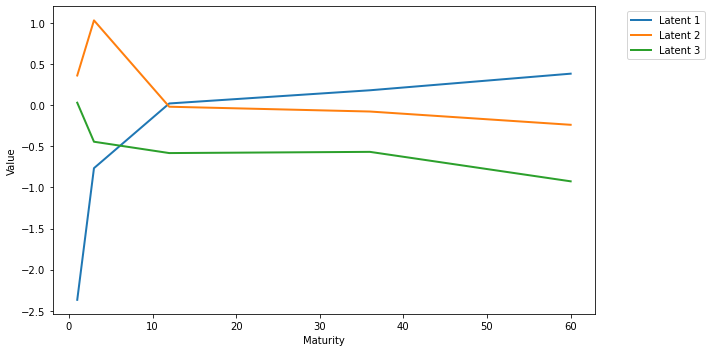

In [21]:
def plot_B(B):

    # Plotting the columns
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(mats, B[-3, :], linestyle='-', linewidth=2)
    ax.plot(mats, B[-2, :], linestyle='-', linewidth=2)
    ax.plot(mats, B[-1, :], linestyle='-', linewidth=2)
    ax.legend(['Latent 1', 'Latent 2', 'Latent 3'], 
              bbox_to_anchor=(1.05, 1), 
              loc='upper left')
    ax.set_xlabel('Maturity')
    ax.set_ylabel('Value')


    # Adjust position of labels
    plt.tight_layout()

    plt.show()

plot_B(B)

The figure above displays the yield weights, denoted as $B_n$, as a function of maturity, denoted as n, for the contemporaneous state variables in the system. These weights indicate the impacts of latent factors on yields across all maturities. Due to time constraints, I will not discuss the implications in detail. However, it is worth mentioning that when I changed the estimation period (changed from 1080-12 to 2002-12), I obtained very similar results to the original paper, despite using different proxies for inflation and economic growth. This suggests that the estimation method is effective. The reader can also compare the results by uncommenting a line in the second cell of Section 2.

### 5.2 Impulse Responses 

Here, I am going to define a function that plots the impulse responses of the yield curve to macroeconomic shocks. This will actually give us the answer to the question we asked in the beginning. Because we are working with time series, it is not straightforward how a change in one of the observable state variables can affect the yield curve. This is because a change in one period can affect the curve in multiple periods. So the coefficients in the final observation equation that we obtained do not give us the desired information. On the other hand, impulse responses are used in Vector Autoregression to understand the dynamic relationship between variables. They represent the effect of a shock to one variable on the other variables over time. Impulse responses provide insights into the short-term and long-term responses of the system, helping to analyze the interdependencies and transmission mechanisms among variables.

Impulse responses can be easily calculated here due to the affine form of both the state dynamics and the observation equation (check section 4.1). We observed that our final state variables can be expressed in a VAR(1) form, wherein the impulse responses can be obtained by iteratively multiplying the lagged coefficients with the impulse vector and summing the resulting effects over time. In section 3.2, the results of the VAR(12) are presented, and since we normalized the factors before estimation, we obtained a very small mean; thus, we assumed a zero mean for the latent factors. Although the mean was included in the estimation process, we omit it here as it would complicate the computation without affecting the variation, only the level of the shocks. By repeatedly substituting the lagged values of $X_t$, under some conditions (as outlined [here](https://kevinkotze.github.io/ts-7-var/)), the equation becomes $X_t = \sum ^{\infty }_{i=0}\Phi ^{i}\Sigma \epsilon_{t-i}$, where $\Phi ^{i}\Sigma$ quantifies the impact on each variable in $X_t$ if there is a shock in one of the variables (each row represents one variable). Substituting this equation into the yield equation, $y_t^n = A_n + B_n' X_t$, yields $y_t^n = A_n + \sum ^{\infty }_{i=0}B_n'\Phi ^{i}\Sigma \epsilon_{t-i}$, where $B_n'\Phi ^{i}\Sigma$ represents the desired quantity. 

The code provided below does the same computation. And plots $B_n'\Phi ^{i}\Sigma$s for 60 periods (i = 1, 2, ..., 60) or five years below. I plot only the impulse responses for macro variables, because the ones for latent variables have no economic interpretation.

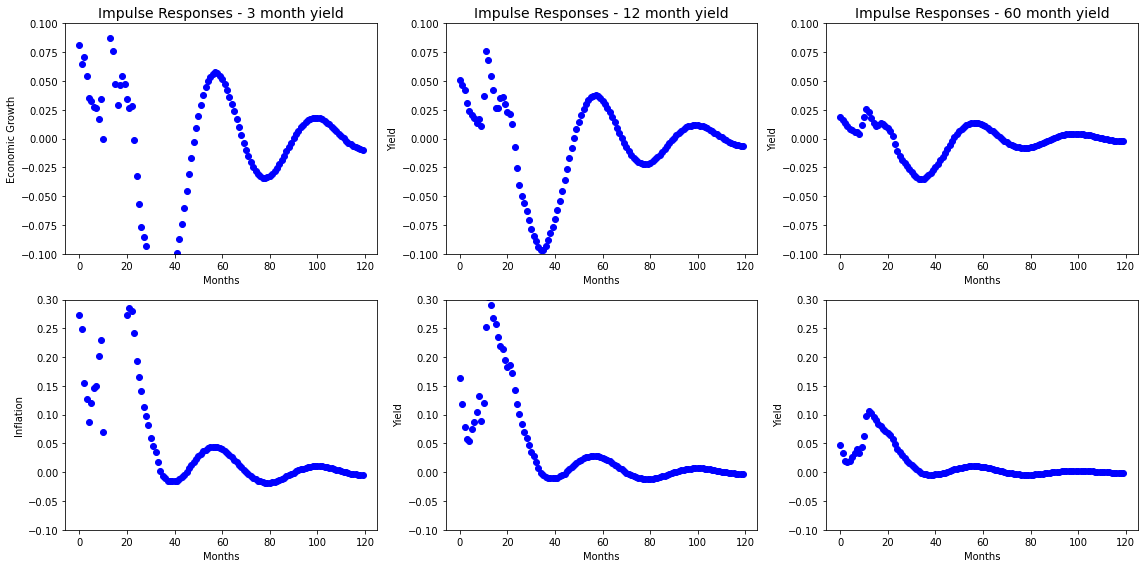

In [18]:
def plot_IRs(B, phi, sigma, months):
    """
    Plots the impulse responses of the yield curve to economic factors.
    """
    
    # VMA(inf) coefficients and shocks 
    u = np.array([i for i in range(months)])
    
    # Plot IR
    titles = ["Impulse Responses - 3 month yield", 
              "Impulse Responses - 12 month yield", 
              "Impulse Responses - 60 month yield"]
    
    maturities = [3, 12, 60]

    plt_vars = ['Economic Growth', 'Inflation']
    
    fig, ax = plt.subplots(nrows=len(plt_vars), ncols=len(maturities), figsize=(16, 8))

    for i, mat in enumerate(maturities):
        for j, v in enumerate(plt_vars):
            # Compute IRs
            IR = np.array([(
                B[:, maturities.index(mat)] @ np.linalg.matrix_power(phi, n=n) @ sigma)[j] for n in range(months)]
                )
            ax[j, i].scatter(u, IR, c='b')
            ax[j, i].set(xlabel='Months', ylabel='Yield')
            if j == 0:
                ax[j, i].set_title(titles[i], fontsize=14)
            if i == 0:
                ax[j, i].set_ylabel(plt_vars[j])  # Set the variable name as the y-axis label
        ax[0, i].set_ylim(bottom=-0.1, top=0.1)
        ax[1, i].set_ylim(bottom=-0.1, top=0.3)

    plt.tight_layout()
    plt.show()

plot_IRs(B, phi, sigma, months=120)


Above, you can observe the impulse responses from macroeconomic shocks to the yield curve as implied by the affine term structure model. Due to the time limit I will not discuss the implication of the IRs, but it is evident that shocks to the macro variables have a greater impact on the short end of the yield curve in comparison to the long end. 

### 5.3 Strenght and Limitation

Term structure models include their ability to capture the dynamics and relationships between interest rates of different maturities, allowing for the estimation of yield curves and the pricing of various fixed-income securities. These models also provide a flexible framework to incorporate market information, such as current interest rates and yield spreads, aiding in the analysis of risk and the assessment of market expectations.

Affine term structure models have several strengths that make them widely used in finance. Firstly, they offer analytical tractability, allowing for explicit solutions and efficient computation of bond prices and yield curves. Secondly, they provide a framework to capture important features of the term structure, such as mean reversion and volatility, allowing for the modeling of interest rate dynamics over time. Lastly, affine models can incorporate a wide range of market information and data, enabling more accurate pricing, risk management, and hedging strategies in fixed-income markets. They also have a very important role in asset pricing and monetary banking theory

However, they also have some limitations. In this particular case, it is assumed that the latent factors and macro factors are not correlated, which, in fact, is not very realistic. To see why, just consider an observable factor that affects the interest rate and is correlated with either inflation or economic growth. By allowing latent factors to be correlated with the observable factors, the model's performance can be improved. Another limitation is their assumption of linearity in the relationship between interest rates and state variables, which may not fully capture the complex dynamics observed in real-world interest rate movements. This can lead to potential inaccuracies in pricing and risk assessment, particularly during periods of extreme market conditions or structural shifts. Additionally, affine models may struggle to capture certain features of the yield curve, such as non-monotonic shapes or anomalies, requiring more sophisticated models or additional adjustments to achieve better accuracy. 

## 6. Conlusion

In conclusion, the main outcome of this project was the estimation of an Affine Term Structure Model to understand the relationship between macroeconomic variables and the term structure of interest rates. In the first lecture, we learned how to estimate the hidden states when the parameters are given. Here, I showed how to estimate parameters and compute the hidden states when you don't have the parameters. This allowed for the pricing of bonds and the estimation of latent factors that drive the yield curve. The estimation process involved implementing the Kalman Filter algorithm and using Least Squares optimization to estimate the model parameters and the latent factors. I was not surprised by the overall findings of the project, as they align with the existing theories and empirical evidence on interest rates and bond pricing. I compared my results when using a shorter period of data and obtained similar results to the original paper, which also indicates that the estimation works.

This was the first time I estimated such a big model, and I have to say that I learned a lot. It was very challenging for me, and I was very stressed because I had many difficulties during this process. At the same time, I have never had as many dopamine spikes in my life as I had while working on this project. I really enjoyed the process, and I hope that someone will benefit from the codes or the explanation of the model that I provide here.

Readers should take away an understanding of what affine term structures are, their importance, and how they can be estimated using the Kalman filter. Further work could be done to extend the analysis of the ATSM. One possible extension is to incorporate more macroeconomic variables to capture additional factors that drive the term structure of interest rates. Additionally, exploring different estimation specifications, such as correlated state variables, could provide a more robust model. Moreover, conducting out-of-sample forecasting tests would help assess the model's predictive power and its ability to capture changes in the yield curve over time. Overall, there are various avenues for further research and refinement of the Affine Term Structure Model framework.


### Whats Next?

In this project, I have presented one classic example of the affine term structure family and constructed it. Due to time limitations, I wasn't able to assemble everything into a class, which may complicate the process of implementing the model by others. I will continue working on this project, combining the codes into one class, and attempting to use Kalman MLE to fit the curve and compare the results with my findings. Nevertheless, I hope someone finds this project helpful. 

Please **contact** me if you: (i) find any mistakes, (ii) have any questions, or (iii) would like to obtain the updated version of the Notebook. My email is geghamyanvahan@gmail.com.

## Appendix A

**Note**: The following appendix is directly copied from Ang and Piazzesi (2003). It is modified to be consistent with the notation here.

For a oneperiod bond, $n=1$, we have:
$$
\begin{aligned}
p_t^1 & =\mathrm{E}_t\left[m_{t+1}\right]=\exp \left\{-r_t\right\} \\
& =\exp \left\{-\delta_0-\delta_1^{\prime} X_t\right\} .
\end{aligned} \tag{A1}
$$

Matching coefficients leads to $\bar{A}_{1}=-\delta_{0}$ and $\bar{B}_{1}=-\delta_{1}$. Suppose that the price of an $n$-period bond is given by $p_{t}^{n}=\exp \left(\bar{A}_{n}+\bar{B}_{n}^{\prime} X_{t}\right)$. Now we show that the exponential form also applies to the price of the $n+1$ period bond:

$$
\begin{aligned}
p_{t}^{n+1}= & \mathrm{E}_{t}\left[m_{t+1} p_{t+1}^{n}\right] \\
= & \mathrm{E}_{t}\left[\exp \left\{-r_{t}-\frac{1}{2} \lambda_{t}^{\prime} \lambda_{t}-\lambda_{t}^{\prime} \varepsilon_{t+1}+\bar{A}_{n}+\bar{B}_{n}^{\prime} X_{t+1}\right\}\right] \\
= & \exp \left\{-r_{t}-\frac{1}{2} \lambda_{t}^{\prime} \lambda_{t}+\bar{A}_{n}\right\} \mathrm{E}_{t}\left[\exp \left\{-\lambda_{t}^{\prime} \varepsilon_{t+1}+B_{n}^{\prime} X_{t+1}\right\}\right] \\
= & \exp \left\{-r_{t}-\frac{1}{2} \lambda_{t}^{\prime} \lambda_{t}+\bar{A}_{n}\right\} \mathrm{E}_{t}\left[\exp \left\{-\lambda_{t}^{\prime} \varepsilon_{t+1}+\bar{B}_{n}^{\prime}\left(\mu+\phi X_{t}+\Sigma \varepsilon_{t+1}\right)\right\}\right] \\
= & \exp \left\{-\delta_{0}+\bar{A}_{n}+B_{n} \mu+\left(B_{n}^{\prime} \phi-\delta_{1}^{\prime}\right) X_{t}-\frac{1}{2} \lambda_{t}^{\prime} \lambda_{t}\right\} \\
& \times \mathrm{E}_{t}\left[\exp \left\{-\left(\lambda_{t}^{\prime}+\bar{B}_{n}^{\prime} \Sigma\right) \varepsilon_{t+1}\right\}\right] \\
= & \exp \left\{-\delta_{0}+\bar{A}_{n}+\bar{B}_{n}^{\prime}\left(\mu-\Sigma \lambda_{0}\right)+\frac{1}{2} \bar{B}_{n}^{\prime} \Sigma \Sigma^{\prime} \bar{B}_{n}-\delta_{1}^{\prime} X_{t}\right. \\
& \left.+B_{n}^{\prime} \phi X_{t}-B_{n} \Sigma \lambda_{1} x_{t}\right\} .
\end{aligned}  \tag{A2}
$$

The last equality relies on $\varepsilon_{t}$ being IID normal with $E\left[\varepsilon_{t}\right]=0$ and a degenerate variance-covariance matrix $\operatorname{var}\left[\varepsilon_{t}\right]$ which contains many zeros (see Eq. (8)). Also, $\lambda_{t}$ contains zero submatrices (see Eq. (8)). Taken together, these assumptions imply that $\lambda_{t}^{\prime} \lambda_{t}=\lambda_{t}^{\prime} \operatorname{var}\left(\varepsilon_{t}\right) \lambda_{t}$. Matching coefficients results in the recursive relations in Eqs. (14).

<a id="Appendix_B"></a>
## Appendix B

In this appendix I summarise and present the intuition behind the affine term structure model by explaining one of the simpleset model that was proposed by in 1977 by Vasicek. I hope the reader will find it interesting and illustrative. I also hope that after reading it you will understand the intuition behind many steps in the model construction stage.

By specifying a process for the short rates and assuming that there are no arbitrage opportunities, it can be shown that the whole-term structure of interest rates can be expressed as a function of the current value of the short rate. One popular model that links the term structure to the short rate is the Vasicek model, where the factor determining the term structure is the instantaneous short rate that follows a mean-reverting Gaussian process (Vasicek, 1977). This model is a one- factor Markov model of the short rate. In other words, the short rate is assumed to be influenced by a single latent factor, which follows a Markov process, this means that interest rate movements are driven by only one source of market risk. In the next subsection, I will introduce the Vasicek model. Then, I will explain how it can be extended and discuss its relationship to the model in Secion 3.



## Vasicek 

The Vasicek interest rate model is one of the earliest and simplest models that describes the evolution of interest rates over time. The model is described by the following differential equation: 

\begin{equation}
    dr(t) =  (\alpha - \beta r(t))dt + \sigma dW(t) \tag{B1}
\end{equation}

Where:
- $r(t)$ is the short-term interest rate at time t.
- $\beta$ is the speed of mean reversion parameter.
- $\alpha$ is the long-term mean or equilibrium interest rate multiplied by reversion rate, $\beta$.
- $dt$ signifies the time increment, indicating that the deterministic term affects the interest rate over a small time interval.
- $\sigma$ is the volatility parameter, representing the instantaneous standard deviation of the interest rate.
- $dW(t)$ is a Wiener process or Brownian motion, representing random shocks or fluctuations in the interest rate over time.


$dr(t)$ represents the change in the short-term interest rate at time t. The model incorporates mean reversion, which is represented by the deterministic part of the model, $(\alpha - \beta r(t))dt$. This is the trend of the process, which is changing. When the interest rate, $r(t)$, is very high, $(\alpha - \beta r(t))$ is negative and so the interest rate is pulled down. Similarly, when the interest rate is very low, the trend becomes positive and the interset rate is being reverted to it. $\beta$ determines how fast the interest rate reverts to the mean. Figure 1 illustrates this mean reversion process. The term $\sigma dW(t)$ represents the random fluctuation or volatility in the interest rate. 

I will not explain the details behind Brownian motion, but you can think of it as a **continuous** version of a random walk. Like a random walk, Brownian motion is a mathematical model that describes a process where future steps are unpredictable and determined solely by random movements or changes. The only difference is that Brownian motion moves infinitely faster and takes infinitely small steps. For more details, refer to Chapter 3 of Shreve (2010).

<div style="text-align: center">
    <img src="HW_Figure31_1.png" alt="Figure 1: Mean Reversion" />
    <p style="text-align: center">Figure 1: Mean Reversion</p>
</div>

(Source: [Hull, 2018](#H))

Equation (A1) represents a stochastic differential equation (SDE) that defines the random process that describes the stochastic law of motion for $r(t)$. The SDE (1) has a closed-form solution:

\begin{equation}
    r(t) = e^{-\beta t} r(0) + \frac{\alpha}{\beta}\left(1 - e^{-\beta t}\right) + \sigma e^{-\beta t} \int_0^t e^{\beta s} dW(s) \tag{B2}
\end{equation}

Here, $\int_0^t e^{\beta s} dW(s) \sim N(0, \int_0^t e^{2 \beta s} ds)$.

This implies that $r(t)$ follows a normal distribution with a mean of $r(0) + \frac{\alpha}{\beta}\left(1 - e^{-\beta t}\right)$ and a variance of $\frac{\sigma^2}{2\beta}\left(1 - e^{-2 \beta t}\right)$. It's important to note that the distribution changes as $t$ changes.

For a detailed derivation of equation (2), refer to Chapter 4 of Shreve (2010). The proof of normality can be found in Chapter 3.

The crucial aspect here is that by estimating the parameters of equation (1), we can obtain the distribution of the interest rate for any given time $t$. Thus, the parameters can be estimated using Maximum Likelihood Estimation (MLE).



However, in this simple case, it would be easier to estimate the parameters using Ordinary Least Squares (OLS). To estimate the Vasicek model, we first need to discretize it.

This can be done by substituting the continuous terms in equation (1) with their discrete analogues:
1. $r(t) \rightarrow r_t$
2. $dt \rightarrow \Delta t$
3. $dr(t) \rightarrow \Delta r_t$
4. $dW(t) \rightarrow \epsilon_t \sqrt{\Delta t}$

The equation (1) then becomes:

\begin{equation}
\begin{aligned}
    \Delta r_t &= (\alpha - \beta r_t) \Delta t + \sigma \epsilon_t \sqrt{\Delta t} \\
    &= \alpha \Delta t - \beta r_t \Delta t + \sigma \epsilon_t \sqrt{\Delta t} \\
    &= \frac{\alpha}{12} - \frac{\beta}{12} r_t + \frac{\sigma}{\sqrt{12}} \epsilon_t
\end{aligned}
\tag{B3} \substack{\text{for monthly data} \\ \Delta t = \frac{1}{12}}
\end{equation}

Thus, by simply regressing $\Delta r_t$ on $r_t$, we can compute the parameters as follows:

$$\Delta r_t = \underbrace{\hat{a}}_{\alpha / 12} + \underbrace{\hat{b}}_{- \beta / 12} r_t + \underbrace{\hat{u}_t}_{\frac{\sigma}{\sqrt{12}} \epsilon_t}$$

Here, $\hat{a}$ and $\hat{b}$ represent the regression intercept and slope coefficient, respectively. $\hat{u}_t$ is the regression residual.


We can infer the model parameters $\alpha$, $\beta$ and $\sigma$ in the following way:

1. $\hat{\alpha} = 12 \hat{a}$
2. $\hat{\beta} = - 12 \hat{b}$
3. $\hat{\sigma} = \sqrt{12} \hat{\sigma}_{u_t}$, where $\hat{\sigma}_{u_t}$ is the standard error of the regression (we note that $std(\epsilon_t) = 1$)

In [19]:
from sklearn.linear_model import LinearRegression

R_t = yields_data['1m'].copy()
dR_t = R_t.diff(1)
R_t = R_t.to_numpy()[1:].reshape(-1, 1)
dR_t = dR_t.to_numpy()[1:]

# Create and fit the linear regression model
model = LinearRegression().fit(R_t, dR_t)

# Print the estimated parameters
print(f"beta: {-12 * model.coef_[0]: 0.3f}")
print(f"alpha: {12 * model.intercept_: 0.3f}")
print(f"sigma: {np.sqrt(12) * np.std(dR_t - model.predict(R_t)): 0.3f}")



beta: -0.037
alpha: -0.340
sigma:  1.633


These parameters indicate that the short rate reverts to 4.04 % ($\alpha / \beta$ = long-term mean) with a reversion rate of 26.2%. The volatility of the short rate at any given time is 0.72% divided by the short rate.

Using the Vasicek model, under the no-arbitrage assumption, we can express the price of a zero-coupon bond as follows:

$$P(t,T) = \exp\left(-A(t,T) - B(t,T)r(t)\right) \tag{B4}
$$

where $A(t,T)$ and $B(t,T)$ are nonrandom functions and are given by:

$$A(t,T) = \left(\frac{1 - e^{-\beta(T-t)}}{\beta}\right)\left(\frac{\alpha}{\beta} - \frac{\sigma^2}{2\beta^2}\right) - \frac{\sigma^2}{4\beta}e^{-\beta(T-t)}  \tag{B5}
$$

$$B(t,T) = \frac{1 - e^{-\beta(T-t)}}{\beta}  \tag{B6}
$$

In these equations, $T$ represents the bond's maturity time. This equation states that at time $t$, the value of the discount bond with maturity date $T$ is exponentially affine in the interest rate. 

Exponentially affine means that the logarithm of the bond's price is an affine function (a linear function combined with a constant term) of the interest rate.

By plugging in the appropriate values for $t$, $T$, $r(t)$, $\beta$, $\alpha$, and $\sigma$, you can calculate the price of a zero-coupon bond using the above formulas derived from the Vasicek interest rate model.


<div class="alert alert-block alert-info">
    <b>Intuition: Solving for As and Bs</b> 
    
The coefficients mentioned above can be directly related to the ones in Section 3.4. Here, they are much simpler and continuous, depending only on maturity, whereas in Section 3.4, they depend on both time and maturity. Providing a proof would require knowledge of Stochastic Differential Equations, which won't be covered here. However, if you are familiar with differential equations, you can think about it like this: We know the stochastic process governing the short rate (B1), but we have limited knowledge about the yields and how they relate to the interest rate, given by $dP(t, T) = f(r, t, T)$. To solve for P in this case, we assume a specific form for $P(t, T)$ (B4), compute $dP(t, T)$, and equate the terms corresponding to $dt$ and $dW(t)$ (the Brownian motion). Due to the presence of Brownian motion, the rules for taking derivatives and integrals differ from those in Calculus.

Now, we have seen the motivation for assuming an exponentially affine form for P(t, T) in (B4) in the continuous case. In Section 3.3, we work with stochastic difference equations instead of stochastic differential equations. In Appendix A, the authors follow the same logic to compute the affine coefficients.

</div>


In this simplest model, we implicitly assume that $r(t) = r(t)$. However, this model can be extended to include multiple factors. For example:

$$
r(t) = b_0 + b_1X_1(t) + b_2X_2(t) \tag{B7}
$$

Each factor $X_1(t)$ and $X_2(t)$ follows the following dynamics:

$$
dX_i(t) = (\alpha_i - \beta_i X_i(t) - \beta_j X_j(t))dt + \sigma_i dW_i(t) + \sigma_i dW_j(t) \tag{B8}
$$

where $i$ and $j$ can take the values of 1 or 2, and $i \neq j$.

This framework can be extended in numerous ways, although listing all of them is beyond the scope of this discussion. However, the specification presented in Section 3 provides the most general case for the Vasicek model.

## A short literature review

Many term structure models have used latent factor models to explain term structure movements, and although there are some interpretations of what these factors mean, the factors are not given a direct comparison with macroeconomic variables (Duffie and Kan, 1996). 

Duffie and Kan (1996) presented a consistent and arbitrage-free affine multi-factor model of the term structure of interest rates in which yields at selected fixed maturities follow a parametric multivariate Markov diffusion process, with “stochastic volatility”. **In their work, they showed that affine term structure models yield closed-form expressions for zero-coupon-bond prices**. 

Dai and Singleton (2000) have suggested that the entire yield curve moves primarily in response to changes in a small number of latent factors (normally three), but the factors themselves are typically described based on their effects on the “level, slope, and curvature” of the yield curve, rather than in terms of the financial and economic fundamentals that drive market interest rates. **They provided the complete characteristics of affine term structure model categories and specified the conditions for identifying such models**.

Ang and Piazzesi (2003) introduced a discrete-time affine term structure model, where both observed and unobserved information are included in the information governing bond markets and the process governing this information is in the form of a vector autoregression (VAR). Their approach is a discrete-time variant of Duffie and Kan's (1996) affine class, in which bond prices are exponential affine functions of underlying state variables, with some of the state variables being observed as macroeconomic aggregates.

<div class="alert alert-block alert-info">
    <b>Intuition: Affine short rate</b> 
    
As we have observed, the short rate is assumed to be an affine function of certain latent factors in the model we discussed. On the other hand, the Taylor rule assumes that the short rate is an affine function of three variables: economic growth, inflation, and monetary shock. In Section 3.1, we combined these two specifications together by decomposing the macroeconomic shocks into three components (a.k.a. three latent factors). They explain the variation in the short rates that the traditional macro factors cannot explain.
</div>

### References

Ang, A., & Piazzesi, M. (2003). A no-arbitrage vector autoregression of term structure dynamics with macroeconomic and latent variables. Journal of Monetary Economics, 50(4), 745–787. https://doi.org/10.1016/s0304-3932(03)00032-1

Baker, B. (2014). A Computational Approach to Affine Models of the Term Structure. In Google Books. American University. https://books.google.com/books/about/A_Computational_Approach_to_Affine_Model.html?id=jOTYjwEACAAJ

Cochrane, J. H. (2008). Asset Pricing : (Revised). Princeton University Press.

Dai, Q., & Singleton, K. J. (2000). Specification Analysis of Affine Term Structure Models. The Journal of Finance, 55(5), 1943–1978. https://doi.org/10.1111/0022-1082.00278

Duffie, D., & Kan, R. (1996). A YIELD-FACTOR MODEL OF INTEREST RATES. Mathematical Finance, 6(4), 379–406. https://doi.org/10.1111/j.1467-9965.1996.tb00123.x

A First Look at the Kalman Filter. (n.d.). Intermediate Quantitative Economics with Python. Retrieved July 7, 2023, from https://python.quantecon.org/kalman.html

Hull, J. (2018). Options, futures, and other derivatives. Chennai Pearson.

Mishkin, F. S. (2015). The economics of money, banking, and financial markets. Pearson.

Murphy, K. P. (2022). Probabilistic machine learning : an introduction. The Mit Press.

Pei, Y., Biswas, S., Fussell, D. S., & Pingali, K. (2019). An elementary introduction to Kalman filtering. Communications of the ACM, 62(11), 122–133. https://doi.org/10.1145/3363294

Schlooz, M. (2019). The Vasicek Model Fitted By The Kalman Filter Applied To The Long-Run Term Structure. https://www.netspar.nl/assets/uploads/P20190821_MSc012_Schlooz.pdf

Shreve, S. E. (2010). Stochastic calculus for finance. II, Continuous-time models. Springer.

Taylor, John B. (1993). Discretion versus policy rules in practice. In Carnegie-Rochester conference series on public policy (Vol. 39, pp. 195–214). Elsevier.

Vasicek, O. (1977). An equilibrium characterization of the term structure. Journal of Financial Economics, 5(2), 177–188. https://doi.org/10.1016/0304-405x(77)90016-2

Woodford, M. (2003). Interest and prices: foundations of a theory of monetary prices. Princeton University Press.